In [1]:
import tensorflow as tf
print("TF version: ", tf.__version__)

TF version:  2.3.1


In [2]:
from transformers import AutoConfig, AutoModel, TFAutoModel, AutoTokenizer

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve

from data_preprocessing import remove_stop_words, text_normalization, add_data_portion

from keras.models import Model
from keras.layers import Input, Dense, LSTM, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

#### Load Dataset

In [5]:
spanish_dataset = pd.read_csv('../data/Merged/spanish_dataset.csv')
spanish_dataset
#print(spanish_dataset.shape)

,text,label
0,"RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...",1
1,"La palabra ""haiga"", aceptada por la RAE La Rea...",1
2,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,1
3,UNAM capacitará a maestros para aprobar prueba...,0
4,Alerta: pretenden aprobar libros escolares con...,1
...,...,...
2566,"Recuperamos la historia de Aleixandra, la jove...",0
2567,"Reproches, tensión y sinceridad: la comida en ...",0
2568,"RT @ElMundoOpinion: ""PSOE, PP, Ciudadanos y Vo...",0
2569,Rusia cita al embajador español por unas decla...,0


#### Load BETO Model

In [6]:
config = AutoConfig.from_pretrained('../data/bert_beto/config.json')
#model = AutoModel.from_pretrained('../data/bert_beto/model.ckpt-2000000.index', from_tf=True, config=config)
beto = TFAutoModel.from_pretrained('../data/bert_beto/pytorch_model.bin', from_pt=True, config=config)
print(config, beto)

{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 31002
}


In [7]:
max_length_sequence = 150

In [8]:
#tokenizer = AutoTokenizer.from_pretrained('../data/bert_beto/vocab.txt')
tokenizer = AutoTokenizer.from_pretrained('../data/bert_beto/vocab.txt', do_lower_case=True, add_special_tokens=True,
                                          max_length=max_length_sequence, pad_to_max_length=True)
tokenizer

#### Prepare Data

In [9]:
def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.encode(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

def get_masks(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

In [10]:
def normalize_and_tokenize_data(df, max_length_sequence):
    text_normalization(df) # Normalize text
    remove_stop_words(df, language = 'spanish', get_tokenize = False) # Remove stop words [and Tokenize texts]
    
    all_sentences = df['text'].values
    all_words = []
    for sent in all_sentences:
        temp = []
        temp.append('[CLS]')
        i = 0
        for w in tokenizer.tokenize(sent):
            i+=1
            if i == (max_length_sequence - 1): break
            temp.append(w)
        temp.append('[SEP]')
        all_words.append(temp)

    return all_words

In [11]:
def get_inputs(spanish_dataset, max_length_sequence):

    all_words = normalize_and_tokenize_data(spanish_dataset, max_length_sequence)

    input_ids = np.zeros((len(all_words), max_length_sequence))
    input_masks = np.zeros((len(all_words), max_length_sequence))
    input_segments = np.zeros((len(all_words), max_length_sequence))

    for i in range(len(all_words)):
        input_ids[i,:] = np.array(get_ids(all_words[i], tokenizer, max_length_sequence)).reshape(1,-1)
        input_masks[i,:] = np.array(get_masks(all_words[i], max_length_sequence)).reshape(1,-1)
        input_segments[i,:] = np.array(get_segments(all_words[i], max_length_sequence)).reshape(1,-1)

    input_ids = input_ids.astype(int)
    return (input_ids, input_masks, input_segments)

#### Models

In [12]:
batch_size = 32

In [13]:
def create_model_CNN(max_length_sequence, filters, kernel_size, dense_units, l2_kernel):
    
    input_word_ids = Input(shape=(max_length_sequence, ), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_length_sequence, ), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_length_sequence, ), dtype=tf.int32, name="segment_ids")
    
    embedding_layer = beto(input_word_ids, attention_mask=input_mask, token_type_ids=segment_ids)
    
    X = Conv1D(filters = filters, kernel_size = kernel_size, activation = 'relu',
              kernel_regularizer = regularizers.l2(l2_kernel))(embedding_layer[0])
    X = MaxPooling1D(pool_size = 2)(X)
    X = Flatten()(X)
    X = Dense(units = dense_units, activation = 'relu')(X)
    X = Dense(units = 1, activation = 'sigmoid')(X)
                          
    model = Model(inputs = [input_word_ids, input_mask, segment_ids], outputs = X)
    
    for layer in model.layers[:4]:
        layer.trainable = False
    
    return(model)

In [13]:
def create_model_RNN(max_length_sequence, lstm_units, l2_kernel, l2_recurrent, l2_activity, dropout):
    
    input_word_ids = Input(shape=(max_length_sequence, ), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_length_sequence, ), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_length_sequence, ), dtype=tf.int32, name="segment_ids")
    
    embedding_layer = beto(input_word_ids, attention_mask=input_mask, token_type_ids=segment_ids)
    
    X = LSTM(units = lstm_units, return_sequences = False,
            kernel_regularizer = regularizers.l2(l2_kernel),
            recurrent_regularizer = regularizers.l2(l2_recurrent),
            activity_regularizer = regularizers.l2(l2_activity))(embedding_layer[0])
    
    X = Dropout(rate = dropout)(X)
    X = Dense(units = 1, activation = 'sigmoid')(X)
                          
    model = Model(inputs = [input_word_ids, input_mask, segment_ids], outputs = X)
    
    for layer in model.layers[:4]:
        layer.trainable = False
                          
    return(model)

#### Execute Models

In [14]:
input_ids, input_masks, input_segments = get_inputs(spanish_dataset, max_length_sequence)
print(input_ids.shape, input_masks.shape, input_segments.shape)

(2571, 150) (2571, 150) (2571, 150)


In [52]:
print(input_ids[0])
print(input_masks[0])
print(input_segments[0])

[    4 29047  6249 30956  3269 10296 18116  6949 10406  1083  4543  1105
  1626  2322  1498 10406 30956  2078  2570  7105 10406  1519 29047  1785
  1130 27832  1637 30957  3180  4898  3120 14825 30957  1935  6249 30956
 17576 10296  2035  3269 18116  6949 10406  1083  1785  1130 24861  1092
 10296  5868 30956  9869  1626  2322  1498  1626  3756  2397  3382 30957
  3269  7288  8173  6949  7035 14327  8636  4293  3603  1688  3469  6949
  7035  8173 10406  1083  8636  5508  3464  1105  1845 11469  5181 17576
 30958 30380 11712  8173  8636  2570  2338  2053  2749  1497 10296 18972
 30956  1665  6949  4500  8168  7035  2652  3758 30956  9869  1626  2322
  1498  9179 30956 10194  2397 25065 30958  1973  1556 30956  5334 10296
 15067 30956 29310  1524 26635 30957 25719  4412  1207  1524  1916  2322
 17576 15903 10799  3269 12630  6949  7035  1894  6584 18116  4002 10406
  1519 13981  1170  3269  3207     5]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 

In [17]:
test_size = 0.1
Y = spanish_dataset.label.values

input_ids_tr, input_ids_te, input_masks_tr, input_masks_te, input_segments_tr, input_segments_te, y_tr, y_te = train_test_split(
    input_ids, input_masks, input_segments, Y, test_size = test_size, shuffle = True)

In [18]:
print(len(input_ids_tr), len(input_ids_te))
print(len(input_masks_tr), len(input_masks_te))
print(len(input_segments_tr), len(input_segments_te))
print(len(y_tr), len(y_te))

2313 258
2313 258
2313 258
2313 258


##### outcomes with max_length_sequence = 150

RNN

In [31]:
epochs = 40

In [19]:
RNN = create_model_RNN(max_length_sequence = max_length_sequence, lstm_units = 8, l2_kernel = 0, l2_recurrent = 0, l2_activity = 0, dropout = 0.5)
RNN.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) # Compile model
RNN.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 150)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 150)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 150, 768), ( 109850880   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [20]:
RNN.fit([input_ids_tr, input_masks_tr, input_segments_tr], y_tr, epochs = epochs, batch_size = batch_size, shuffle = True) # Fit model
loss, acc = RNN.evaluate([input_ids_te, input_masks_te, input_segments_te], y_te) # Evaluate model
print(loss, round(acc, 3))
RNN.save_weights('../data/Weights/BETO_RNN.h5')

Epoch 1/40
73/73 [==============================] - 1091s 15s/step - loss: 0.6741 - accuracy: 0.5841
Epoch 2/40
73/73 [==============================] - 1020s 14s/step - loss: 0.6174 - accuracy: 0.6753
Epoch 3/40
73/73 [==============================] - 1003s 14s/step - loss: 0.5965 - accuracy: 0.6762
Epoch 4/40
73/73 [==============================] - 1031s 14s/step - loss: 0.5722 - accuracy: 0.7043
Epoch 5/40
73/73 [==============================] - 959s 13s/step - loss: 0.5648 - accuracy: 0.7103
Epoch 6/40
73/73 [==============================] - 942s 13s/step - loss: 0.5521 - accuracy: 0.7224
Epoch 7/40
73/73 [==============================] - 892s 12s/step - loss: 0.5179 - accuracy: 0.7505
Epoch 8/40
73/73 [==============================] - 837s 11s/step - loss: 0.5138 - accuracy: 0.7475
Epoch 9/40
73/73 [==============================] - 911s 12s/step - loss: 0.5121 - accuracy: 0.7575
Epoch 10/40
73/73 [==============================] - 903s 12s/step - loss: 0.4974 - accuracy: 0.

In [22]:
CNN = create_model_CNN(max_length_sequence = max_length_sequence, filters = 16, kernel_size = 10, dense_units = 4, l2_kernel = 0)
CNN.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) # Compile model
CNN.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 150)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 150)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 150, 768), ( 109850880   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

##### outcomes max_length_sequence = 200 + early_stopping

RNN

In [32]:
epochs = 40

In [33]:
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    min_delta = 0.1,
    mode = 'max',
    restore_best_weights = True
)

In [34]:
validation_split = 0.1

In [35]:
RNN = create_model_RNN(max_length_sequence = max_length_sequence, lstm_units = 8, l2_kernel = 0, l2_recurrent = 0, l2_activity = 0, dropout = 0.5)
RNN.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) # Compile model

In [36]:
RNN.fit([input_ids_tr, input_masks_tr, input_segments_tr], y_tr, epochs = epochs, batch_size = batch_size, shuffle = True, 
        validation_split = validation_split, callbacks=[early_stopping]) # Fit model

loss, acc = RNN.evaluate([input_ids_te, input_masks_te, input_segments_te], y_te) # Evaluate model
print(round(loss, 3), round(acc, 3))
RNN.save_weights('../data/Weights/BETO_RNN_v2.h5')

Epoch 1/40
66/66 [==============================] - 1117s 17s/step - loss: 0.6680 - accuracy: 0.5766 - val_loss: 0.6343 - val_accuracy: 0.6638
Epoch 2/40
66/66 [==============================] - 984s 15s/step - loss: 0.6168 - accuracy: 0.6684 - val_loss: 0.5796 - val_accuracy: 0.7155
Epoch 3/40
66/66 [==============================] - 940s 14s/step - loss: 0.6140 - accuracy: 0.6569 - val_loss: 0.5626 - val_accuracy: 0.7198
Epoch 4/40
66/66 [==============================] - 943s 14s/step - loss: 0.5667 - accuracy: 0.7198 - val_loss: 0.5549 - val_accuracy: 0.7284
Epoch 5/40
66/66 [==============================] - 953s 14s/step - loss: 0.5375 - accuracy: 0.7439 - val_loss: 0.5202 - val_accuracy: 0.7716
Epoch 6/40
66/66 [==============================] - 951s 14s/step - loss: 0.5366 - accuracy: 0.7501 - val_loss: 0.5229 - val_accuracy: 0.7629
Epoch 7/40
66/66 [==============================] - 959s 15s/step - loss: 0.5089 - accuracy: 0.7669 - val_loss: 0.5272 - val_accuracy: 0.7155
Epoch

CNN

In [37]:
CNN = create_model_CNN(max_length_sequence = max_length_sequence, filters = 16, kernel_size = 10, dense_units = 4, l2_kernel = 0)
CNN.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) # Compile model

In [38]:
CNN.fit([input_ids_tr, input_masks_tr, input_segments_tr], y_tr, epochs = epochs, batch_size = batch_size, shuffle = True, 
       validation_split = validation_split, callbacks=[early_stopping]) # Fit model

loss, acc = CNN.evaluate([input_ids_te, input_masks_te, input_segments_te], y_te) # Evaluate model
print(round(loss, 3), round(acc, 3))
CNN.save_weights('../data/Weights/BETO_CNN_v2.h5')

Epoch 1/40
66/66 [==============================] - 967s 15s/step - loss: 0.6991 - accuracy: 0.4849 - val_loss: 0.6930 - val_accuracy: 0.5302
Epoch 2/40
66/66 [==============================] - 957s 14s/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.5302
Epoch 3/40
66/66 [==============================] - 957s 15s/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.5302
Epoch 4/40
66/66 [==============================] - 956s 14s/step - loss: 0.6932 - accuracy: 0.4733 - val_loss: 0.6931 - val_accuracy: 0.5302
Epoch 5/40
66/66 [==============================] - 966s 15s/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6930 - val_accuracy: 0.5302
Epoch 6/40
9/9 [==============================] - 76s 8s/step - loss: 0.6932 - accuracy: 0.4922
0.693 0.492


##### outcomes max_length_sequence = 150 + early_stopping

RNN

In [18]:
epochs = 40
validation_split = 0.1

In [19]:
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    min_delta = 0.05,
    mode = 'max',
    restore_best_weights = True
)

In [20]:
RNN = create_model_RNN(max_length_sequence = max_length_sequence, lstm_units = 8, l2_kernel = 0, l2_recurrent = 0, l2_activity = 0, dropout = 0.5)
RNN.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) # Compile model

In [21]:
RNN.fit([input_ids_tr, input_masks_tr, input_segments_tr], y_tr, epochs = epochs, batch_size = batch_size, shuffle = True, 
        validation_split = validation_split, callbacks=[early_stopping]) # Fit model

loss, acc = RNN.evaluate([input_ids_te, input_masks_te, input_segments_te], y_te) # Evaluate model
print(round(loss, 3), round(acc, 3))
RNN.save_weights('../data/Weights/BETO_RNN_E_S_val_acc.h5')

Epoch 1/40
66/66 [==============================] - 778s 12s/step - loss: 0.6743 - accuracy: 0.5776 - val_loss: 0.6205 - val_accuracy: 0.6767
Epoch 2/40
66/66 [==============================] - 793s 12s/step - loss: 0.6183 - accuracy: 0.6684 - val_loss: 0.6297 - val_accuracy: 0.6164
Epoch 3/40
66/66 [==============================] - 778s 12s/step - loss: 0.5951 - accuracy: 0.6824 - val_loss: 0.5629 - val_accuracy: 0.7069
Epoch 4/40
66/66 [==============================] - 772s 12s/step - loss: 0.5695 - accuracy: 0.7088 - val_loss: 0.5456 - val_accuracy: 0.7500
Epoch 5/40
66/66 [==============================] - 764s 12s/step - loss: 0.5467 - accuracy: 0.7184 - val_loss: 0.5412 - val_accuracy: 0.7371
Epoch 6/40
66/66 [==============================] - 748s 11s/step - loss: 0.5506 - accuracy: 0.7299 - val_loss: 0.5391 - val_accuracy: 0.7155
Epoch 7/40
66/66 [==============================] - 750s 11s/step - loss: 0.5336 - accuracy: 0.7381 - val_loss: 0.4967 - val_accuracy: 0.7931
Epoch 

In [22]:
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    min_delta = 0.1,
    mode = 'min',
    restore_best_weights = True
)

In [23]:
RNN = create_model_RNN(max_length_sequence = max_length_sequence, lstm_units = 8, l2_kernel = 0, l2_recurrent = 0, l2_activity = 0, dropout = 0.5)
RNN.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) # Compile model

In [24]:
RNN.fit([input_ids_tr, input_masks_tr, input_segments_tr], y_tr, epochs = epochs, batch_size = batch_size, shuffle = True, 
        validation_split = validation_split, callbacks=[early_stopping]) # Fit model

loss, acc = RNN.evaluate([input_ids_te, input_masks_te, input_segments_te], y_te) # Evaluate model
print(round(loss, 3), round(acc, 3))
RNN.save_weights('../data/Weights/BETO_RNN_E_S_val_loss.h5')

Epoch 1/40
66/66 [==============================] - 748s 11s/step - loss: 0.6832 - accuracy: 0.5656 - val_loss: 0.6358 - val_accuracy: 0.6681
Epoch 2/40
66/66 [==============================] - 765s 12s/step - loss: 0.6203 - accuracy: 0.6598 - val_loss: 0.5789 - val_accuracy: 0.7026
Epoch 3/40
66/66 [==============================] - 756s 11s/step - loss: 0.5826 - accuracy: 0.6881 - val_loss: 0.5678 - val_accuracy: 0.7155
Epoch 4/40
66/66 [==============================] - 727s 11s/step - loss: 0.5709 - accuracy: 0.7189 - val_loss: 0.5646 - val_accuracy: 0.6983
Epoch 5/40
66/66 [==============================] - 718s 11s/step - loss: 0.5604 - accuracy: 0.7242 - val_loss: 0.5464 - val_accuracy: 0.7414
Epoch 6/40
9/9 [==============================] - 61s 7s/step - loss: 0.6228 - accuracy: 0.6938
0.623 0.694


25 epochs without early_stopping

In [25]:
epochs = 25

In [26]:
RNN = create_model_RNN(max_length_sequence = max_length_sequence, lstm_units = 8, l2_kernel = 0, l2_recurrent = 0, l2_activity = 0, dropout = 0.5)
RNN.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) # Compile model

In [27]:
RNN.fit([input_ids_tr, input_masks_tr, input_segments_tr], y_tr, epochs = epochs, batch_size = batch_size, shuffle = True) # Fit model
loss, acc = RNN.evaluate([input_ids_te, input_masks_te, input_segments_te], y_te) # Evaluate model
print(round(loss, 3), round(acc, 3))
RNN.save_weights('../data/Weights/BETO_RNN_NO_E_S_25e.h5')

Epoch 1/25
73/73 [==============================] - 713s 10s/step - loss: 0.6812 - accuracy: 0.5793
Epoch 2/25
73/73 [==============================] - 709s 10s/step - loss: 0.6289 - accuracy: 0.6485
Epoch 3/25
73/73 [==============================] - 705s 10s/step - loss: 0.6093 - accuracy: 0.6844
Epoch 4/25
73/73 [==============================] - 722s 10s/step - loss: 0.5621 - accuracy: 0.7216
Epoch 5/25
73/73 [==============================] - 730s 10s/step - loss: 0.5547 - accuracy: 0.7207
Epoch 6/25
73/73 [==============================] - 734s 10s/step - loss: 0.5297 - accuracy: 0.7475
Epoch 7/25
73/73 [==============================] - 719s 10s/step - loss: 0.5138 - accuracy: 0.7622
Epoch 8/25
73/73 [==============================] - 709s 10s/step - loss: 0.4919 - accuracy: 0.7717
Epoch 9/25
73/73 [==============================] - 702s 10s/step - loss: 0.4860 - accuracy: 0.7696
Epoch 10/25
73/73 [==============================] - 701s 10s/step - loss: 0.4749 - accuracy: 0.7838

In [55]:
epochs = 25
test_size = 0.1
total_models = 4

Y = spanish_dataset.label.values
input_ids, input_masks, input_segments = get_inputs(spanish_dataset, max_length_sequence)
test_acc_avg = 0

for i in range(total_models):
    
    input_ids_tr, input_ids_te, input_masks_tr, input_masks_te, input_segments_tr, input_segments_te, y_tr, y_te = train_test_split(
        input_ids, input_masks, input_segments, Y, test_size = test_size, shuffle = True)
    
    RNN = create_model_RNN(max_length_sequence = max_length_sequence, lstm_units = 8, l2_kernel = 0, l2_recurrent = 0, l2_activity = 0, dropout = 0.5)
    RNN.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) # Compile model
    
    RNN.fit([input_ids_tr, input_masks_tr, input_segments_tr], y_tr, epochs = epochs, batch_size = batch_size, shuffle = True) # Fit model
    loss, acc = RNN.evaluate([input_ids_te, input_masks_te, input_segments_te], y_te) # Evaluate model
    print(round(loss, 3), round(acc, 3))
    print('---')
    test_acc_avg += acc
    RNN.save_weights('../data/Weights/BETO_RNN_M_'+ str(i) +'.h5')

print('test_acc_avg: ' + str(test_acc_avg / total_models))

Epoch 1/25
73/73 [==============================] - 693s 9s/step - loss: 0.6712 - accuracy: 0.5854
Epoch 2/25
73/73 [==============================] - 691s 9s/step - loss: 0.6142 - accuracy: 0.6628
Epoch 3/25
73/73 [==============================] - 691s 9s/step - loss: 0.5936 - accuracy: 0.6827
Epoch 4/25
73/73 [==============================] - 691s 9s/step - loss: 0.5713 - accuracy: 0.7034
Epoch 5/25
73/73 [==============================] - 697s 10s/step - loss: 0.5462 - accuracy: 0.7233
Epoch 6/25
73/73 [==============================] - 695s 10s/step - loss: 0.5271 - accuracy: 0.7475
Epoch 7/25
73/73 [==============================] - 689s 9s/step - loss: 0.5108 - accuracy: 0.7596
Epoch 8/25
73/73 [==============================] - 692s 9s/step - loss: 0.4892 - accuracy: 0.7765
Epoch 9/25
73/73 [==============================] - 696s 10s/step - loss: 0.4903 - accuracy: 0.7748
Epoch 10/25
73/73 [==============================] - 692s 9s/step - loss: 0.4714 - accuracy: 0.7873
Epoch 

---

#### Confusion Matrix for LSTM

In [49]:
def plot_confusion_matrix(y_true, y_pred, normalize):
    if normalize:
        cm = confusion_matrix(y_true, y_pred, normalize = 'true')
    else:
        cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['Real News', 'Fake News'])
    disp = disp.plot(cmap='Blues')
    plt.show()

Epoch 1/25
73/73 [==============================] - 828s 11s/step - loss: 0.6733 - accuracy: 0.5837
Epoch 2/25
73/73 [==============================] - 780s 11s/step - loss: 0.6186 - accuracy: 0.6602
Epoch 3/25
73/73 [==============================] - 764s 10s/step - loss: 0.5968 - accuracy: 0.6982
Epoch 4/25
73/73 [==============================] - 773s 11s/step - loss: 0.5696 - accuracy: 0.7198
Epoch 5/25
73/73 [==============================] - 762s 10s/step - loss: 0.5608 - accuracy: 0.7289
Epoch 6/25
73/73 [==============================] - 778s 11s/step - loss: 0.5422 - accuracy: 0.7432
Epoch 7/25
73/73 [==============================] - 764s 10s/step - loss: 0.5254 - accuracy: 0.7471
Epoch 8/25
73/73 [==============================] - 765s 10s/step - loss: 0.5105 - accuracy: 0.7497
Epoch 9/25
73/73 [==============================] - 771s 11s/step - loss: 0.4935 - accuracy: 0.7704
Epoch 10/25
73/73 [==============================] - 760s 10s/step - loss: 0.4701 - accuracy: 0.7799

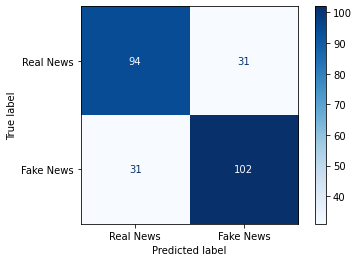

Epoch 1/25
73/73 [==============================] - 782s 11s/step - loss: 0.6776 - accuracy: 0.5763
Epoch 2/25
73/73 [==============================] - 780s 11s/step - loss: 0.6185 - accuracy: 0.6636
Epoch 3/25
73/73 [==============================] - 787s 11s/step - loss: 0.5848 - accuracy: 0.6982
Epoch 4/25
73/73 [==============================] - 779s 11s/step - loss: 0.5734 - accuracy: 0.7082
Epoch 5/25
73/73 [==============================] - 785s 11s/step - loss: 0.5519 - accuracy: 0.7263
Epoch 6/25
73/73 [==============================] - 778s 11s/step - loss: 0.5234 - accuracy: 0.7454
Epoch 7/25
73/73 [==============================] - 799s 11s/step - loss: 0.5156 - accuracy: 0.7605
Epoch 8/25
73/73 [==============================] - 779s 11s/step - loss: 0.4813 - accuracy: 0.7847
Epoch 9/25
73/73 [==============================] - 779s 11s/step - loss: 0.5253 - accuracy: 0.7432
Epoch 10/25
73/73 [==============================] - 774s 11s/step - loss: 0.4911 - accuracy: 0.7778

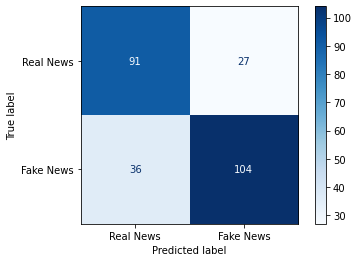

Epoch 1/25
73/73 [==============================] - 759s 10s/step - loss: 0.6714 - accuracy: 0.5923
Epoch 2/25
73/73 [==============================] - 759s 10s/step - loss: 0.6259 - accuracy: 0.6537
Epoch 3/25
73/73 [==============================] - 770s 11s/step - loss: 0.5877 - accuracy: 0.6956
Epoch 4/25
73/73 [==============================] - 764s 10s/step - loss: 0.5728 - accuracy: 0.6995
Epoch 5/25
73/73 [==============================] - 863s 12s/step - loss: 0.5522 - accuracy: 0.7250
Epoch 6/25
73/73 [==============================] - 907s 12s/step - loss: 0.5461 - accuracy: 0.7259
Epoch 7/25
73/73 [==============================] - 881s 12s/step - loss: 0.5248 - accuracy: 0.7458
Epoch 8/25
73/73 [==============================] - 859s 12s/step - loss: 0.5084 - accuracy: 0.7683
Epoch 9/25
73/73 [==============================] - 835s 11s/step - loss: 0.5107 - accuracy: 0.7622
Epoch 10/25
73/73 [==============================] - 843s 12s/step - loss: 0.4999 - accuracy: 0.7613

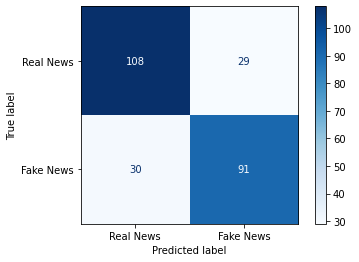

Epoch 1/25
73/73 [==============================] - 826s 11s/step - loss: 0.6714 - accuracy: 0.5875
Epoch 2/25
73/73 [==============================] - 832s 11s/step - loss: 0.6135 - accuracy: 0.6680
Epoch 3/25
73/73 [==============================] - 870s 12s/step - loss: 0.6083 - accuracy: 0.6667
Epoch 4/25
73/73 [==============================] - 846s 12s/step - loss: 0.5678 - accuracy: 0.7108
Epoch 5/25
73/73 [==============================] - 845s 12s/step - loss: 0.5539 - accuracy: 0.7259
Epoch 6/25
73/73 [==============================] - 949s 13s/step - loss: 0.5408 - accuracy: 0.7237
Epoch 7/25
73/73 [==============================] - 1085s 15s/step - loss: 0.5614 - accuracy: 0.7147
Epoch 8/25
73/73 [==============================] - 1025s 14s/step - loss: 0.5143 - accuracy: 0.7523
Epoch 9/25
73/73 [==============================] - 923s 13s/step - loss: 0.5201 - accuracy: 0.7557
Epoch 10/25
73/73 [==============================] - 835s 11s/step - loss: 0.4887 - accuracy: 0.77

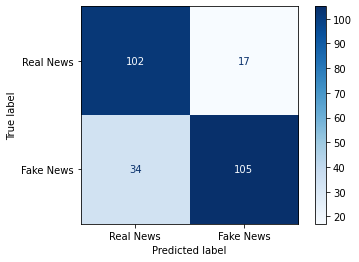

Epoch 1/25
73/73 [==============================] - 766s 10s/step - loss: 0.6814 - accuracy: 0.5612
Epoch 2/25
73/73 [==============================] - 768s 11s/step - loss: 0.6168 - accuracy: 0.6628
Epoch 3/25
73/73 [==============================] - 763s 10s/step - loss: 0.5903 - accuracy: 0.6904
Epoch 4/25
73/73 [==============================] - 767s 11s/step - loss: 0.5671 - accuracy: 0.7056
Epoch 5/25
73/73 [==============================] - 773s 11s/step - loss: 0.5421 - accuracy: 0.7276
Epoch 6/25
73/73 [==============================] - 834s 11s/step - loss: 0.5259 - accuracy: 0.7410
Epoch 7/25
73/73 [==============================] - 776s 11s/step - loss: 0.5254 - accuracy: 0.7371
Epoch 8/25
73/73 [==============================] - 775s 11s/step - loss: 0.4926 - accuracy: 0.7778
Epoch 9/25
73/73 [==============================] - 775s 11s/step - loss: 0.5053 - accuracy: 0.7523
Epoch 10/25
73/73 [==============================] - 765s 10s/step - loss: 0.4981 - accuracy: 0.7596

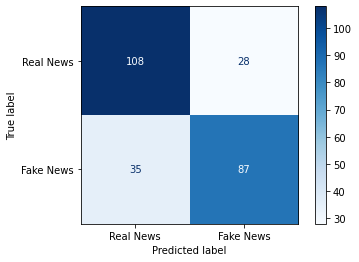

test_acc_avg: 0.768992257118225


In [15]:
epochs = 25
test_size = 0.1
total_models = 5

Y = spanish_dataset.label.values
input_ids, input_masks, input_segments = get_inputs(spanish_dataset, max_length_sequence)
test_acc_avg = 0

for i in range(total_models):
    
    input_ids_tr, input_ids_te, input_masks_tr, input_masks_te, input_segments_tr, input_segments_te, y_tr, y_te = train_test_split(
        input_ids, input_masks, input_segments, Y, test_size = test_size, random_state = i)
    
    RNN = create_model_RNN(max_length_sequence = max_length_sequence, lstm_units = 8, l2_kernel = 0, l2_recurrent = 0, l2_activity = 0, dropout = 0.5)
    RNN.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) # Compile model
    
    RNN.fit([input_ids_tr, input_masks_tr, input_segments_tr], y_tr, epochs = epochs, batch_size = batch_size, shuffle = True) # Fit model
    loss, acc = RNN.evaluate([input_ids_te, input_masks_te, input_segments_te], y_te) # Evaluate model
    print('---')
    test_acc_avg += acc
    
    y_pred = RNN.predict([input_ids_te, input_masks_te, input_segments_te])
    y_pred = y_pred > 0.5 # Sigmoid activation function
    plot_confusion_matrix(y_te, y_pred, normalize = False)
    
    RNN.save_weights('../data/Weights/BETO_RNN_CM_'+ str(i) +'.h5')

print('test_acc_avg: ' + str(test_acc_avg / total_models))

#### Noramalize selected confusion matrix

In [20]:
selected_model = 3
Y = spanish_dataset.label.values
input_ids, input_masks, input_segments = get_inputs(spanish_dataset, max_length_sequence)
test_size = 0.1

In [17]:
RNN = create_model_RNN(max_length_sequence = max_length_sequence, lstm_units = 8, l2_kernel = 0, l2_recurrent = 0, l2_activity = 0, dropout = 0.5)
RNN.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) # Compile model
RNN.load_weights('../data/Weights/BETO_RNN_80.h5') # charge model weights

In [21]:
input_ids_tr, input_ids_te, input_masks_tr, input_masks_te, input_segments_tr, input_segments_te, y_tr, y_te = train_test_split(
    input_ids, input_masks, input_segments, Y, test_size = test_size, random_state = selected_model)

In [26]:
y_pred = RNN.predict([input_ids_te, input_masks_te, input_segments_te])
y_pred = y_pred > 0.5 # Sigmoid activation function

acc: 0.8023


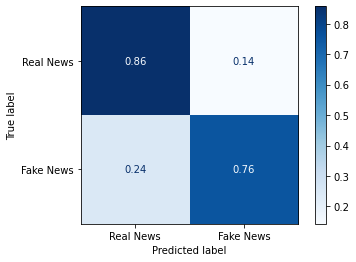

In [50]:
acc = accuracy_score(y_te, y_pred)
print('acc: ' + str(round(acc, 4)))
plot_confusion_matrix(y_te, y_pred, normalize = True)